# Convnext modeling

[original repo link](https://github.com/facebookresearch/ConvNeXt)

In [117]:
import torch
import torchvision
import numpy as np
import random
from torch.nn import functional as F

from torchvision.transforms.functional import to_pil_image
from torch import nn

Prepare some data

In [101]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop(size=(64, 64), scale=(0.6, 1.0)),
    torchvision.transforms.ToTensor(),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(64),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
])


In [102]:
train_data = torchvision.datasets.Imagenette("./.imagenette/", split="train", size="320px", transform=train_transforms, download=False)
val_data = torchvision.datasets.Imagenette("./.imagenette-val/", split="val", size="320px", transform=val_transforms, download=False)

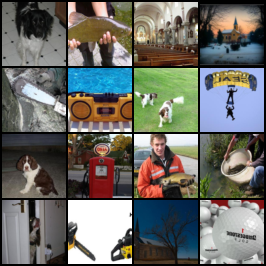

In [121]:
random.seed(42)

to_pil_image(torchvision.utils.make_grid(torch.stack([train_data[random.randint(0, len(train_data) - 1)][0] for _ in range(16)]), nrow=4))

# Model Architecture

What are the key differences between resnet-50 and ConvNeXt architectures?
- stem redesign: single conv layer with kernel size 4 and stride 4 instead of combination of conv layer and max pooling (+0.1%)
- stage ratio 1:1:3:1 or 1:1:9:1 (+0.6%)
- depthwise separable convolutions (introduced in ResNeXt) with inverted bottlenecks (introduced in MobileNet v2) (+1.1%)
- some micro design changes: fewer activations, fewer normalization layers, GELU and LN usage (+0.9%)
- replacing strided convolutions in blocks on separate downscale convolutions (+0.5%)
- improved training technics (+2.7%)
  - Longer training (90 -> 300 epochs) 
  - AdamW optimizer, warm-up, cosine scheduler.
  - Advanced data augmentation techniques: Mixup, Cutmix, RandAugment, Random Erasing
  - Regularization schemes: Stochastic Depth, Label Smoothing
  - LayerScale
  - exponential moving average on network weights

### Depthwise convolutions

In [129]:
channels = 32
kernel_size = 7
depthwise_conv = nn.Conv2d(channels, channels, kernel_size=kernel_size, groups=channels, bias=True)

parameters_size = sum([elem.size().numel() for elem in depthwise_conv.parameters()])
assert parameters_size == (kernel_size*kernel_size*channels + channels), parameters_size

In [130]:
# implement depthwise-separable conv
# compare it's parameters with usual conv

# YOUR CODE HERE

In [ ]:
class ConvNeXtBlockV1(nn.Module):
    """
    Depthwise-separable conv with inverted bottleneck
    """
    def __init__(self, dim: int, scale_rate: int = 4) -> None:
        super().__init__()
        self.dwconv = None  # YOUR CODE
        self.norm = nn.Identity()  # for now
        self.pwconv1 = None  # YOUR CODE
        self.act = nn.GELU()
        self.pwconv2 = None  # YOUR CODE
        self.gamma = None # for now
        self.drop_path = nn.Identity()  # for now

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = input + self.drop_path(x)
        return x

### LayerNorm

[torch LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)

In [ ]:
class LayerNorm2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.ln = nn.LayerNorm(dim)
        
    def forward(self, x):
        # YOUR CODE: make layer norm work with 2d data
        return x

###  LayerScale

LayerScale is a technique used to force residual branch to work more like residual branch.

LayerScale downscales residual branch output with some (learnable) weights which are very small at the begining (1e-6 in paper) but can become larger during training.

Scaling is applied to each channel independenly.

In [132]:
class LayerScale2d(nn.Module):
    def __init__(self, dim, layer_scale_init_value):
        super().__init__()
        self.gamma = None # YOUR CODE. Use nn.Parameter
        
    def forward(self, x):
        x = x * self.gamma
        return x

### Stochastic Depth

[original paper link](https://arxiv.org/pdf/1603.09382.pdf)

[timm implementation](https://github.com/huggingface/pytorch-image-models/blob/82e867769026432dc2ce0082a435679f2abe0d66/timm/layers/drop.py#L170)

In [133]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        # YOUR CODE
        return x

### Final Block

In [134]:
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = None # 7x7 dw conv
        self.norm = LayerNorm2d(dim)
        self.pwconv1 = None 
        self.act = nn.GELU()
        self.pwconv2 = None
        self.gamma = None
        self.drop_path = None

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.gamma(x)
        x = input + self.drop_path(x)
        return x

### ConvNeXt implementation

In [ ]:
import math
import warnings

# copy-pasted from https://github.com/huggingface/pytorch-image-models/blob/82e867769026432dc2ce0082a435679f2abe0d66/timm/layers/weight_init.py#L8
def _trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    # Values are generated by using a truncated uniform distribution and
    # then using the inverse CDF for the normal distribution.
    # Get upper and lower cdf values
    l = norm_cdf((a - mean) / std)
    u = norm_cdf((b - mean) / std)

    # Uniformly fill tensor with values from [l, u], then translate to
    # [2l-1, 2u-1].
    tensor.uniform_(2 * l - 1, 2 * u - 1)

    # Use inverse cdf transform for normal distribution to get truncated
    # standard normal
    tensor.erfinv_()

    # Transform to proper mean, std
    tensor.mul_(std * math.sqrt(2.))
    tensor.add_(mean)

    # Clamp to ensure it's in the proper range
    tensor.clamp_(min=a, max=b)
    return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.

    NOTE: this impl is similar to the PyTorch trunc_normal_, the bounds [a, b] are
    applied while sampling the normal with mean/std applied, therefore a, b args
    should be adjusted to match the range of mean, std args.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    with torch.no_grad():
        return _trunc_normal_(tensor, mean, std, a, b)
####


# adapted from https://github.com/facebookresearch/ConvNeXt/blob/048efcea897d999aed302f2639b6270aedf8d4c8/models/convnext.py#L52
class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf

    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0])
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm2d(dims[i]),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[ConvNeXtBlock(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


### ConvNeXt-like arch for small data

In [135]:
# make stem 2x2 conv w/ stride 2
# make 3 block levels
# make 2x2x2 depths

# YOUR ADAPTATION HERE

## Training technics


### Label smooting

In [136]:
def compute_loss(inputs, target, label_smoothing=0.0):
    # look for F.cross_entropy documentation
    return None

### EMA

[documentation](https://pytorch.org/docs/stable/optim.html#weight-averaging-swa-and-ema)


In [137]:
def create_averaged_model(model, decay=0.999):
    # YOUR CODE
    # HINT: use get_ema_multi_avg_fn
    return None

## Train

In [138]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt


def train_epoch(model, optimizer, train_loader, ema_model, smoothing):
    model.train()
    hist = []
    device = next(model.parameters()).device
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = compute_loss(logits, labels, smoothing)
        loss.backward()
        optimizer.step()
        if ema_model is not None:
            # YOUR CODE
            pass

        hist.append(loss.item())
    return sum(hist) / len(hist)


@torch.no_grad()
def eval_epoch(model, val_loader):
    model.eval()
    device = next(model.parameters()).device
    acc = 0
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        logits = model(images)
        y_pred = logits.max(1)[1].data
        acc += (labels.cpu() == y_pred.cpu()).sum().item()
    return acc / len(val_loader.dataset)


# helper fn
def get_input_for_bn_recompute(data_generator, device):
    for i, (x, y) in enumerate(data_generator):
        x = x.to(device)
        yield x
        # if i == 100:
        #     break


def train(model, optimizer, train_loader, val_loader, epochs, ema_model=None, smoothing=0.0):
    train_hist = defaultdict(list)
    val_hist = defaultdict(list)
    for epoch in range(epochs):
        train_loss = train_epoch(model, optimizer, train_loader, ema_model, smoothing)
        if ema_model is not None:
            # YOUR CODE: update batchnorm statistics
            # hint: use get_input_for_bn_recompute
            pass
        val_acc = eval_epoch(model, val_loader)
        if ema_model:
            ema_val_acc = eval_epoch(ema_model, val_loader)
            val_hist["ema_accuracy"].append(ema_val_acc)
        
        print(f"\tEpoch: {epoch + 1} / {epochs}")
        print(f"\t\tTrain Loss: {train_loss}")
        print(f"\t\tVal acc: {val_acc}")
        if ema_model:
            print(f"\t\tEMA acc: {val_hist['ema_accuracy']}")
        train_hist["loss"].append(train_loss)
        val_hist["accuracy"].append(val_acc)
        clear_output()
        plt.plot(val_hist["accuracy"], label="model")
        if ema_model:
            plt.plot(val_hist["ema_accuracy"], label="ema")
        plt.grid()
        plt.legend(loc='best')
        plt.show()
    return train_hist, val_hist

In [150]:
# Try it out
# Use AdamW as an optimizer
# you can try and add cosine_lr scheduler with warmup
# hint: you can find the impl in the repo

In [151]:
# # cosine lr visualization

# optimizer = torch.optim.Adam(nn.Linear(10, 10).parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)
# sch = []
# for _ in range(1000):
#     sch.append(scheduler.get_last_lr())
#     scheduler.step()
# plt.plot(sch)
# plt.show()

If set everything correctly, then you should hit > 40 acc in 20 epochs

If you want to improve them you can look into:

- Advanced augmentations (cutmix, randaugment etc)
- Try to find better parameters (we weren't following 1:1:3:1 ration)
- Try to use a bigger batch size (maybe gradient accumulation trick may help). In the original paper they used 4k batch size



If you're interested, what comes next, check out [ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders](https://arxiv.org/abs/2301.00808)